# Preprocess data

In [ ]:
import pandas as pd

df = pd.read_csv("fer2013.csv")

print(df.shape)
print(df.head())

(35887, 3)
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training


In [ ]:
import numpy as np

df["img_orig"] = df.pixels.apply(lambda x: np.array(x.split(" ")).reshape(48, 48).astype("float32"))

In [ ]:
# Include 48x48=2304 pixel
len(df["pixels"].iloc[0].split(" "))

2304

In [ ]:
df["img_orig"].iloc[0]

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

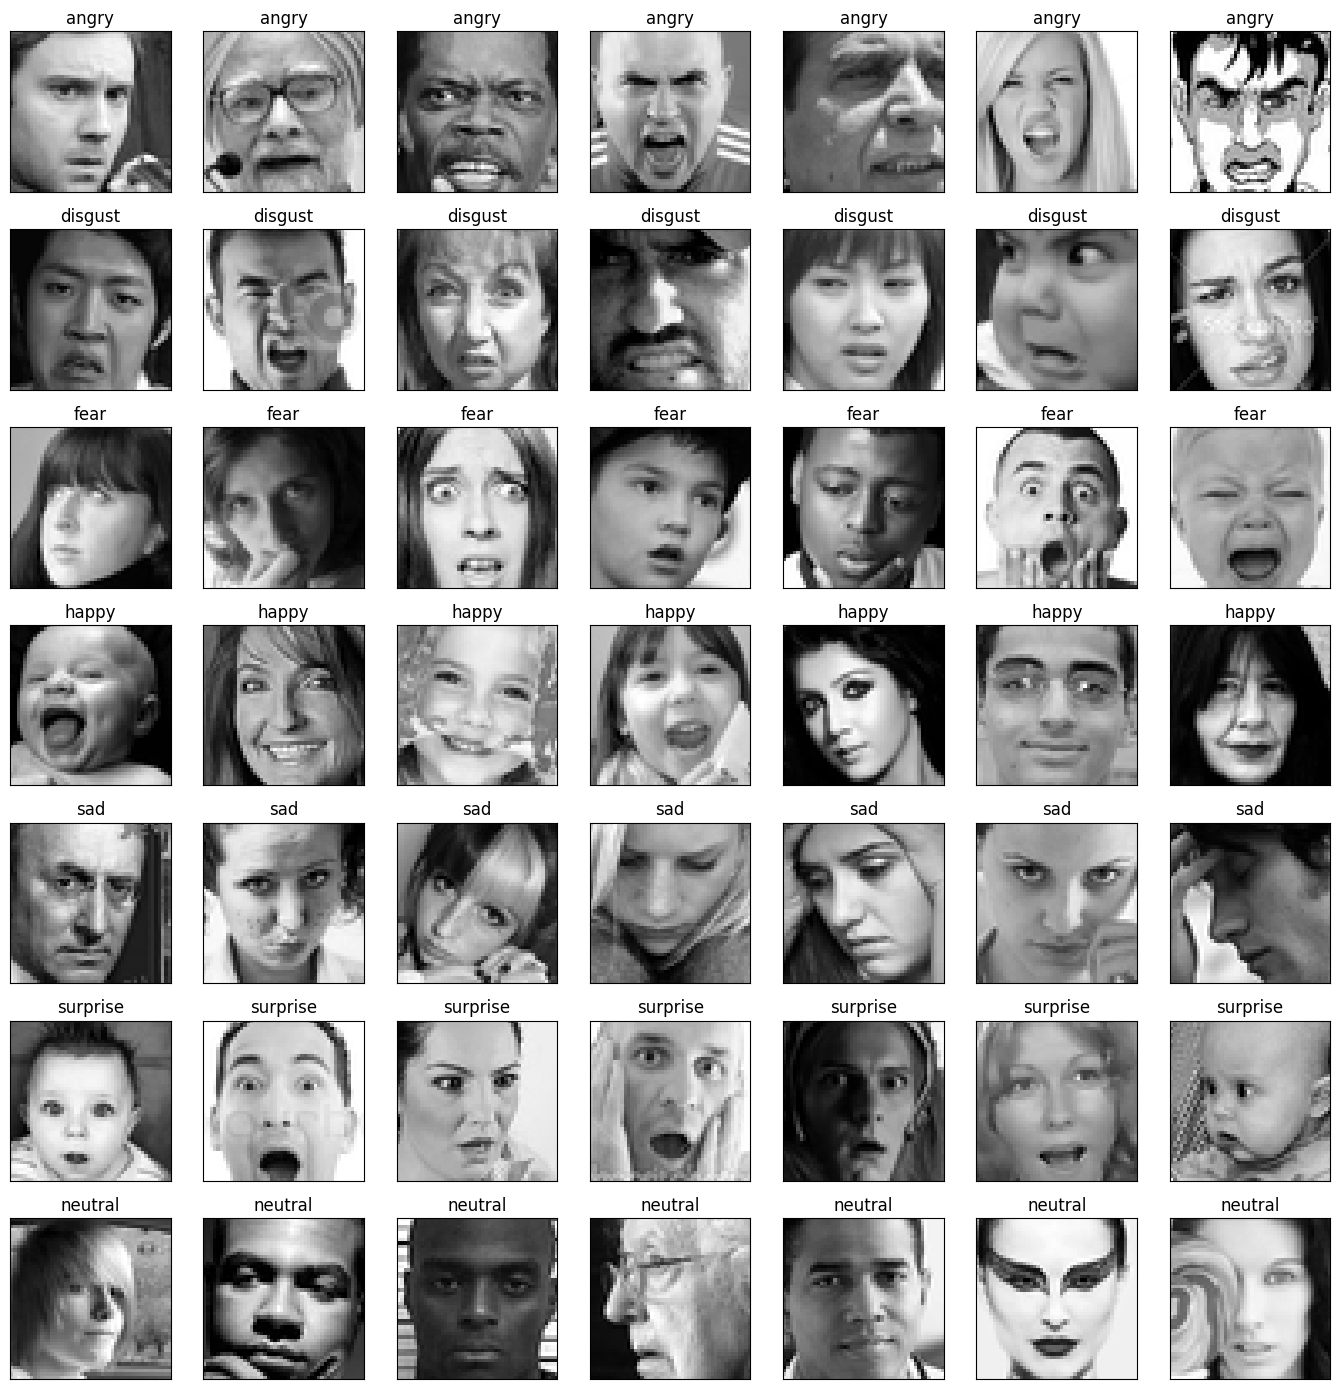

In [ ]:
from matplotlib import pyplot
import numpy as np

fig = pyplot.figure(1, (14, 14))

emotion_label_to_text = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "surprise", 6: "neutral"}

i = 0
for label in sorted(df["emotion"].unique()):
    for j in range(7):
        row = df[df["emotion"] == label].iloc[i]
        row = row["img_orig"]
        i += 1
        ax = pyplot.subplot(7, 7, i)
        ax.imshow(row, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
img_origs = np.stack(df["img_orig"], axis=0)
print(img_origs.shape)

(35887, 48, 48)


In [ ]:
import cv2

img_colors = []
for i in range(len(img_origs)):
    # Convert grayscale image to RGB image
    temp = cv2.cvtColor(img_origs[i], cv2.COLOR_GRAY2RGB)
    img_colors.append(temp)

img_colors = np.array(img_colors)
print(img_colors.shape)

(35887, 48, 48, 3)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()

img_labels = le.fit_transform(df["emotion"])
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

# Split datasets

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    img_colors, img_labels, shuffle=True, stratify=img_labels, test_size=0.15, random_state=42
)

# Split the training set into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, shuffle=True, stratify=y_train, test_size=0.2, random_state=42
)

# Print shapes of the resulting datasets
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((24402, 48, 48, 3),
 (6101, 48, 48, 3),
 (5384, 48, 48, 3),
 (24402, 7),
 (6101, 7),
 (5384, 7))

# Generate data

In [ ]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

valid_datagen = ImageDataGenerator()

# Data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size)

# Train model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D


# Build a model using VGG19 as base
def create_model(input_shape, classes):
    input_tensor = Input(shape=input_shape)

    base_model = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    output = Dense(classes, activation="softmax", name="output_layer")(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model


input_shape = (X_train.shape[1], X_train.shape[2], 3)
num_classes = y_train.shape[1]

model = create_model(input_shape, num_classes)

# print(model.summary())

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set batch size and number of epochs
batch_size = 32
epochs = 50

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=9, mode="min")

# Reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1, mode="min", epsilon=0.001)

# Save the best model during training
model_checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=valid_generator,
    validation_steps=len(X_valid) // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2593 - loss: 1.7884
Epoch 1: val_loss improved from inf to 1.36577, saving model to best_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 73s 80ms/step - accuracy: 0.2594 - loss: 1.7883 - val_accuracy: 0.4704 - val_loss: 1.3658 - learning_rate: 1.0000e-04
Epoch 2/50
  1/762 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.4688 - loss: 1.3318

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.36577 to 1.30380, saving model to best_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4688 - loss: 1.3318 - val_accuracy: 0.3810 - val_loss: 1.3038 - learning_rate: 1.0000e-04
Epoch 3/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4640 - loss: 1.3885
Epoch 3: val_loss improved from 1.30380 to 1.27837, saving model to best_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 52s 68ms/step - accuracy: 0.4641 - loss: 1.3884 - val_accuracy: 0.5100 - val_loss: 1.2784 - learning_rate: 1.0000e-04
Epoch 4/50
  1/762 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.4688 - loss: 1.3089
Epoch 4: val_loss improved from 1.27837 to 1.04948, saving model to best_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 1.3089 - val_accuracy: 0.6667 - val_loss: 1.0495 - learning_rate: 1.0000e-04
Epoch 5/50
762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5117 - loss: 1.2743
Epoch 5: val_loss did not improve from 1.0494

# Test model

In [ ]:
model.save("model.keras")

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6630 - loss: 0.9317
Test accuracy: 0.6594


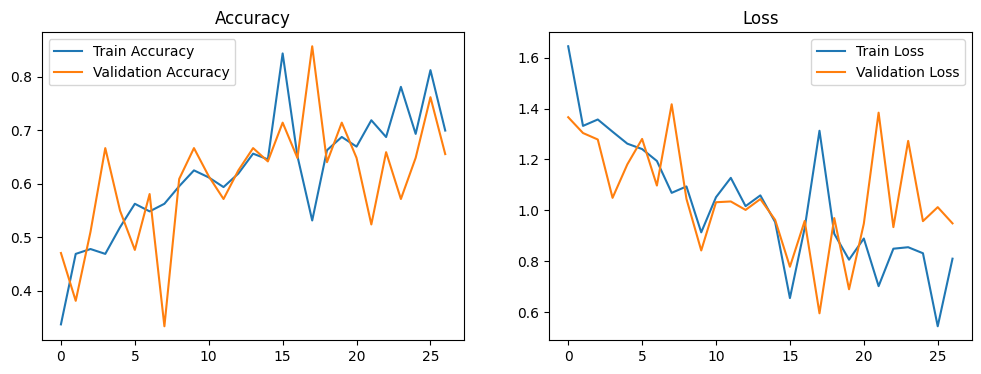

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.show()

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


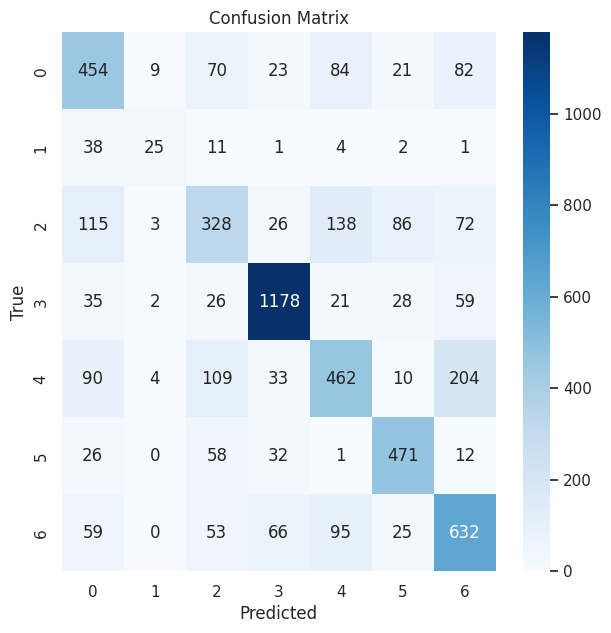

Total wrong validation predictions: 1834


              precision    recall  f1-score   support

           0       0.56      0.61      0.58       743
           1       0.58      0.30      0.40        82
           2       0.50      0.43      0.46       768
           3       0.87      0.87      0.87      1349
           4       0.57      0.51      0.54       912
           5       0.73      0.79      0.76       600
           6       0.60      0.68      0.63       930

    accuracy                           0.66      5384
   macro avg       0.63      0.60      0.61      5384
weighted avg       0.66      0.66      0.66      5384



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict labels for the test set
preds = np.argmax(model.predict(X_test), axis=1)
true_labels = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print number of incorrect predictions
wrong_predictions = np.sum(true_labels != preds)
print(f"Total wrong validation predictions: {wrong_predictions}\n")

# Print classification report
print(classification_report(true_labels, preds))

# Inference

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 722.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124

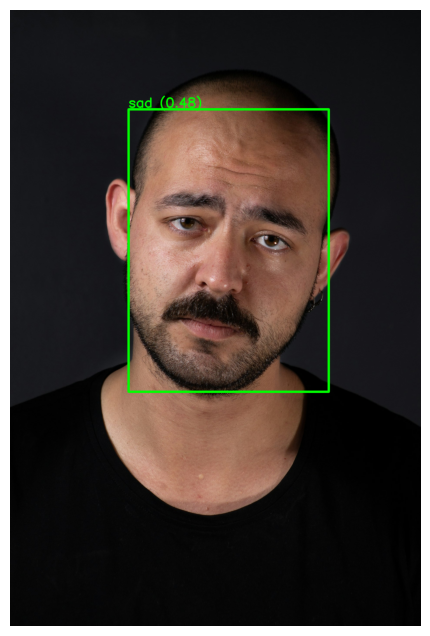

In [ ]:
import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from facenet_pytorch import MTCNN
from tensorflow.keras.models import load_model

# Load pre-trained model
model = load_model("/content/drive/MyDrive/best_model.keras")

# Label mapping
label_map = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "surprise", 6: "neutral"}

# Load image from URL
image_url = "https://images.unsplash.com/photo-1624395213232-ea2bcd36b865?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
if image_url.startswith("http"):
    response = requests.get(image_url)
    img_pil = Image.open(BytesIO(response.content)).convert("RGB")
else:
    img_pil = Image.open(image_url).convert("RGB")
img_cv = np.array(img_pil)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

# Detect faces using MTCNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))
mtcnn = MTCNN(keep_all=True, device=device)
boxes, probs = mtcnn.detect(img_pil)

if boxes is None or len(boxes) == 0:
    print("No face detected.")
else:
    for box, prob in zip(boxes, probs):
        x1, y1, x2, y2 = map(int, box)
        x1, y1 = max(0, x1), max(0, y1)
        w, h = x2 - x1, y2 - y1

        # Crop and preprocess face
        face_crop = img_cv[y1 : y1 + h, x1 : x1 + w]
        face_resized = cv2.resize(face_crop, (48, 48))
        face_norm = face_resized / 255.0
        face_input = np.expand_dims(face_norm, axis=0)

        # Predict emotion
        preds = model.predict(face_input, verbose=0)[0]
        class_id = np.argmax(preds)
        confidence = np.max(preds)
        label = f"{label_map.get(class_id, 'Unknown')} ({confidence:.2f})"

        # Draw bounding box and label
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 10)
        cv2.putText(img_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), 5)

    # Convert back to RGB for display with matplotlib
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()